In [ ]:
import warnings
warnings.filterwarnings('ignore')

import tushare as ts
import talib
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
#import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import joblib # 推荐用于大型模型和NumPy数组
import os
import shap
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import spearmanr

In [ ]:
# -----------------------------------------------------------------------------
# 1. 配置与初始化
# -----------------------------------------------------------------------------
print("初始化 Tushare")
ts.set_token('xxxxxxx') # 占位符
pro = ts.pro_api()

# 设置时间窗口 (2025年视角，训练数据向前推)
START_DATE = '20171201'
END_DATE = '20251201'
# 目标收益率阈值 (8% = 0.08)
TARGET_RETURN_THRESHOLD = 0.08 

def calculate_factors(df):
    """
    输入: 单只股票的日线 DataFrame
    输出: 包含技术指标和基本面因子的 DataFrame
    """
    try:
        df = df.sort_values('trade_date')
        
        # --- 基础数据提取 ---
        close = df['close'].values.astype(float)
        high = df['high'].values.astype(float)
        low = df['low'].values.astype(float)
        volume = df['vol'].values.astype(float) # Tushare中成交量叫vol
        
        # --- A. Momentum ---
        roc20_array = talib.ROC(close, timeperiod=20)
        df['ROC20'] = roc20_array # 20日收益率变化率
        df['TRIX10'] = talib.TRIX(close, timeperiod=10) # 三重指数平滑均线
        df['MOM'] = talib.MOM(close, timeperiod=10)     # 10日动量
        
        # Price Momentum 
        roc_250_array = talib.ROC(close, timeperiod=250)
        
        # PLRC12: 将 NumPy 数组转为 Series 才能用 rolling
        roc_250_series = pd.Series(roc_250_array, index=df.index)
        df['PLRC12'] = roc_250_series.rolling(window=120, min_periods=1).mean()
        
        df['Price1M'] = df['close'].pct_change(periods=20) # 20日收益率 ≈ 1月收益率
        
        # --- B. Emotional/Risk ---
        df['ATR14'] = talib.ATR(high, low, close, timeperiod=14)   # 真实波动幅度均值
        df['RSI14'] = talib.RSI(close, timeperiod=14)              # 相对强弱指数
        vol20_array = talib.STDDEV(close, timeperiod=20, nbdev=1)
        df['VOL20'] = vol20_array # 20日波动率 (标准差)
        
        # *NEW* 波动率相关因子
        df['Variance20'] = df['VOL20'] ** 2 # 方差
        
        # 修正 sharpe_ratio_20: 对 ROC20 NumPy 结果使用 rolling
        roc20_series = pd.Series(roc20_array, index=df.index)
        vol20_series = pd.Series(vol20_array, index=df.index)
        
        # 使用 Series 的 rolling
        df['sharpe_ratio_20'] = roc20_series.rolling(20, min_periods=1).mean() / vol20_series.replace(0, np.nan) 
        
        # --- C. Technical ---
        df['MFI14'] = talib.MFI(high, low, close, volume, timeperiod=14) # 资金流量指标
        
        # MACD
        macd, signal, hist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
        df['MACD'] = macd
        df['MACD_hist'] = hist
        
        # Boll Position
        upper, middle, lower = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        df['boll_up'] = upper # 增加上下轨绝对值
        df['boll_down'] = lower
        with np.errstate(divide='ignore', invalid='ignore'):
            boll_range = upper - lower
            boll_range[boll_range == 0] = np.nan
            df['Boll_Position'] = (close - lower) / boll_range # Boll带百分比位置
        
        ma20_array = talib.SMA(close, timeperiod=20)
        ma60_array = talib.SMA(close, timeperiod=60)
        df['MA20'] = ma20_array # 20日均线
        df['MA60'] = ma60_array # 60日均线
        
        # *NEW* 均线相关
        df['MAC20'] = df['MA20'] - df['MA60'] # 长短期均线差
        
        # *NEW* 成交量相关
        volume_series = pd.Series(volume, index=df.index)
        df['Volume1M'] = volume_series.rolling(20, min_periods=1).mean() # 20日平均成交量
        
        # --- D. Fundamental ---
        
        # 估值倒数 (BP, EP)
        # (BP, EP, size, liquidity 部分保持不变，因为它们是对 Pandas 列的操作)
        if 'pb' in df.columns:
            df['BP'] = 1 / df['pb'].replace([0, np.inf, -np.inf], np.nan)
        else:
            df['BP'] = np.nan
            
        if 'pe_ttm' in df.columns:
            df['EP'] = 1 / df['pe_ttm'].replace([0, np.inf, -np.inf], np.nan)
        else:
            df['EP'] = np.nan

        # 市值/规模 (Size)
        if 'total_mv' in df.columns:
            df['size'] = np.log(df['total_mv'] * 10000)
        else:
            df['size'] = np.nan
            
        # Turnover
        if 'turnover_rate' in df.columns:
            df['liquidity'] = df['turnover_rate'].rolling(20, min_periods=1).mean()
        else:
            df['liquidity'] = np.nan
            
        return df
        
    except Exception as e:
        print(f"因子计算错误: {e}")
        return None
# -----------------------------------------------------------------------------
# 3. 标签构建模块
# -----------------------------------------------------------------------------
def make_targets(df_monthly):
    """
    根据用户需求构建二分类标签:
    下月收益率 > TARGET_RETURN_THRESHOLD (8%) 为 A 类 (1)，其他为 B 类 (0)
    """
    # 1. 计算下个月收益率 (Next Month Return)
    # 逻辑：(下月收盘价 - 本月收盘价) / 本月收盘价
    df_monthly['next_mth_return'] = df_monthly['close'].pct_change().shift(-1)
    
    # 2. 移除最后一行 (因为无法计算下个月收益)
    df_monthly = df_monthly.dropna(subset=['next_mth_return'])
    
    if df_monthly.empty:
        return df_monthly

    # 3. 构建二分类标签 (Binary Labeling)
    # A 类 (1): next_mth_return > 0.08
    # B 类 (0): next_mth_return <= 0.08
    df_monthly['return_group'] = np.where(
        df_monthly['next_mth_return'] > TARGET_RETURN_THRESHOLD,
        1,  # A类
        0   # B类
    )
    
    return df_monthly

# -----------------------------------------------------------------------------
# 4. 数据处理流水线 (Pipeline) 
# -----------------------------------------------------------------------------
def process_stock(stock_code):
    try:
        # Step 1: 获取日线行情
        df_price = pro.daily(ts_code=stock_code, start_date=START_DATE, end_date=END_DATE,
                             fields='ts_code,trade_date,open,high,low,close,vol')
        if df_price.empty: return None
        
        # Step 2: 获取每日指标 (基本面)
        try:
            # 注意：这里会获取新的基本面数据 total_mv
            df_basic = pro.daily_basic(ts_code=stock_code, start_date=START_DATE, end_date=END_DATE,
                                       fields='ts_code,trade_date,turnover_rate,pe_ttm,pb,total_mv')
        except:
            df_basic = pd.DataFrame() # 降级处理
            
        # Step 3: 合并
        if not df_basic.empty:
            df = pd.merge(df_price, df_basic, on=['ts_code', 'trade_date'], how='inner')
        else:
            df = df_price
            df['pe_ttm'] = np.nan
            df['pb'] = np.nan
            df['turnover_rate'] = np.nan
            df['total_mv'] = np.nan
            
        if df.empty: return None
        
        # Step 4: 清洗与排序
        df['trade_date'] = pd.to_datetime(df['trade_date'])
        df = df.sort_values('trade_date').set_index('trade_date')
        df = df[df['vol'] > 0] # 去除停牌
        
        if len(df) < 60: return None # 数据太短无法计算MA60
        
        # Step 5: 计算因子 (日频)
        df = calculate_factors(df)
        if df is None: return None
        
        # Step 6: 降采样为月频 (Monthly Resample)
        try:
            df_monthly = df.resample('ME').last() # Pandas 2.0+
        except:
            df_monthly = df.resample('M').last()  # 旧版 Pandas
            
        # Step 7: 构建目标变量与标签 (二分类)
        df_monthly = make_targets(df_monthly)
        
        if df_monthly.empty: return None
        
        # 添加代码列方便索引
        df_monthly['ts_code'] = stock_code
        
        return df_monthly
        
    except Exception as e:
        print(f"处理 {stock_code} 错误: {e}")
        return None

# -----------------------------------------------------------------------------
# 5. 主程序执行 (保持不变)
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    print("="*60)
    print(f"开始构建因子与二分类标签数据 ({START_DATE} - {END_DATE})")
    print(f"分类标准: 下月收益 > {TARGET_RETURN_THRESHOLD*100}% 为 A 类 (1)，否则为 B 类 (0)")
    print("="*60)
    
    # 1. 获取股票池
    stock_pool = []
    try:
        print("尝试获取沪深300成分股...")
        df_index = pro.index_weight(index_code='000300.SH', start_date='20241201', end_date='20241231')
        if not df_index.empty:
            stock_pool = df_index['con_code'].unique().tolist()
            print(f"成功获取 {len(stock_pool)} 只成分股。")
    except:
        pass
        
    if not stock_pool:
        print("警告：无法通过接口获取成分股，使用扩充测试列表。")
        stock_pool = [
            '600519.SH', '000858.SZ', '601318.SH', '002594.SZ', '300750.SZ',
            '000001.SZ', '600036.SH', '601166.SH', '600900.SH', '000333.SZ'
        ] * 5
    
    # 2. 循环处理
    all_data = []
    print("开始处理股票数据...")
    
    for stock in tqdm(stock_pool):
        res = process_stock(stock)
        if res is not None:
            all_data.append(res)
        time.sleep(0.01) # 稍微暂停防止超频
            
    # 3. 合并与保存
    if all_data:
        full_df = pd.concat(all_data)
        
        # 最终清理：删除特征列全为空的行，并用中位数填充
        feature_cols = [
            'ROC20', 'TRIX10', 'MOM', 'Price1M', 'PLRC12', # 动量
            'ATR14', 'RSI14', 'VOL20', 'Variance20', 'sharpe_ratio_20', # 波动/风险
            'MFI14', 'MACD', 'MACD_hist', 'Boll_Position', 'MA20', 'MA60', 'MAC20', # 技术
            'BP', 'EP', 'size', 'liquidity', 'Volume1M' # 基本面/估值/规模/流动性
        ]
        
        # 填充缺失值 (用中位数)
        for col in feature_cols:
            if col in full_df.columns:
                full_df[col] = full_df[col].fillna(full_df[col].median())
        
        print("\n" + "="*60)
        print("数据构建完成！")
        print(f"总样本数: {len(full_df)}")
        print(f"新增/增强后的特征列表 (共 {len(feature_cols)} 个):")
        print(feature_cols)
        
        # 打印标签分布情况
        print("\n收益率二分类分布 (1=A类>8%, 0=B类<=8%):")
        print(full_df['return_group'].value_counts().sort_index())
        
        # 保存
        filename = 'csi300_binary_datasetversion3.csv'
        full_df.to_csv(filename)
        print(f"数据已保存至: {filename}")
        print("="*60)
        
    else:
        print("错误：未生成任何有效数据。")

In [ ]:
def standardize_and_winsorize(df, factor_cols, limits=(0.01, 0.99)):
    """
    对 DataFrame 进行截面 (Cross-Sectional) 去极值和标准化。
    
    Args:
        df (pd.DataFrame): 包含所有股票所有月度数据的DataFrame。
        factor_cols (list): 需要处理的因子列名列表。
        limits (tuple): 截尾的上下分位数。
        
    Returns:
        pd.DataFrame: 经过处理的 DataFrame。
    """
    print("开始进行截面去极值和标准化...")
    
    # 按照 trade_date (这里是索引) 分组，对每个时间截面进行处理
    def process_cross_section(group):
        for col in factor_cols:
            if col not in group.columns:
                continue

            # 1. 去极值 (Winsorization)
            try:
                # 找到当前截面的分位数
                lower_bound = group[col].quantile(limits[0])
                upper_bound = group[col].quantile(limits[1])
                
                # 截尾处理
                group[col] = np.clip(group[col], lower_bound, upper_bound)
            except Exception as e:
                # 针对数据量太少无法计算分位数的情况
                print(f"Warning: 无法对 {group.name} 的 {col} 进行去极值. Error: {e}")
                
            # 2. 标准化 (Standardization - Z-score)
            mean_val = group[col].mean()
            std_val = group[col].std()
            
            if std_val > 0:
                group[col] = (group[col] - mean_val) / std_val
            else:
                # 如果标准差为零，则所有值都为0
                group[col] = 0.0
                
        return group

    # 使用 groupby().apply() 对每个时间截面进行处理 (索引是 trade_date)
    # level=0 是因为 trade_date 是您在 process_stock 中设置的 Index
    # 如果您没有设置多级索引，这里就是 df.groupby(df.index).apply(...)
    processed_df = df.groupby(df.index).apply(process_cross_section)
    
    # 清理可能产生的多余索引级别
    if isinstance(processed_df.index, pd.MultiIndex) and len(processed_df.index.names) > 1:
        processed_df = processed_df.droplevel(0)

    print("截面预处理完成。")
    return processed_df

def calculate_ic_ir(df, factor_cols):
    """
    计算每个因子在每个时间截面的信息系数 (IC) 和 IC 的均值、IR。
    
    Args:
        df (pd.DataFrame): 包含因子和 next_mth_return 的 DataFrame。
        factor_cols (list): 需要计算 IC 的因子列名列表。
        
    Returns:
        tuple: (ic_df, ic_summary)
    """
    print("\n开始计算信息系数 (IC)...")
    
    ic_dict = {}
    
    # 按时间截面 (trade_date) 分组
    for date, group in tqdm(df.groupby(df.index.get_level_values('trade_date'))):
        ic_values = {}
        if len(group) < 20: # 跳过数据量太小的月份
            continue
            
        for factor in factor_cols:
            if factor not in group.columns:
                continue
            
            # 使用 Spearman 秩相关系数
            correlation = group[[factor, 'next_mth_return']].corr(method='spearman').iloc[0, 1]
            ic_values[factor] = correlation
        
        ic_dict[date] = ic_values

    ic_df = pd.DataFrame.from_dict(ic_dict, orient='index')
    
    # IC 统计指标
    ic_summary = pd.DataFrame({
        'IC_Mean': ic_df.mean(),
        'IC_Std': ic_df.std(),
        'IC_IR': ic_df.mean() / ic_df.std(), # 信息率 (IR) = IC 均值 / IC 标准差
        'IC_Positive_Ratio': (ic_df > 0).sum() / len(ic_df) # IC > 0 的月份占比
    }).sort_values(by='IC_IR', ascending=False)

    print("IC/IR 计算完成。")
    return ic_df, ic_summary

feature_cols = [
    'ROC20', 'TRIX10', 'MOM', 'Price1M', 'PLRC12', 
    'ATR14', 'RSI14', 'VOL20', 'Variance20', 'sharpe_ratio_20', 
    'MFI14', 'MACD', 'MACD_hist', 'Boll_Position', 'MAC20', 
    'BP', 'EP', 'size', 'liquidity', 'Volume1M' 
]

full_df_processed = standardize_and_winsorize(full_df, feature_cols)
ic_df, ic_summary = calculate_ic_ir(full_df_processed, feature_cols)

print("\n" + "="*50)
print("因子有效性分析结果 (按 IR 排序)")
print("="*50)
print(ic_summary)

### 修改后的KNN（生成gap和mean因子）

In [ ]:

def prepare_momentum_features(df, price_col='close'):
    """
    第一步：计算基础动量特征 (ret_5, ret_20)。
    用于后续 KNN 寻找"邻居涨没涨"。
    """
    print("正在计算基础动量特征 (ret_5, ret_20)...")
    df = df.copy()
    
    # 确保按股票代码和时间排序
    if 'trade_date' in df.columns:
        df['trade_date'] = pd.to_datetime(df['trade_date'])
        df = df.sort_values(['ts_code', 'trade_date'])
    else:
        # 如果是 MultiIndex，确保已排序
        df = df.sort_index(level=['ts_code', 'trade_date'])

    # === 计算收益率 (按 ts_code 分组) ===
    # 过去 5 天收益 (短期动量)
    df['ret_5'] = df.groupby('ts_code')[price_col].pct_change(5)
    
    # 过去 20 天收益 (中期动量)
    df['ret_20'] = df.groupby('ts_code')[price_col].pct_change(20)
    
    # 填充 NaN (新上市股票前几天没有收益，填0防止报错)
    df[['ret_5', 'ret_20']] = df[['ret_5', 'ret_20']].fillna(0)
    
    return df

def add_knn_features_optimized(df_processed, feature_cols, k=10):
    """
    第二步：计算 KNN 衍生特征 (向量化极速版)。
    包含核心逻辑：'Gap' (补涨缺口)
    
    Args:
        df_processed: 包含 feature_cols 和 ret_5/ret_20 的数据框
        feature_cols: 用于计算"相似度"的因子列 (必须已标准化)
        k: 邻居数量
    """
    print(f" 开始构建 KNN 特征 (K={k})...")
    
    # 定义我们要观察邻居的哪些表现 (Key: 新特征后缀, Value: 原始列名)
    targets = {
        'mom_1w': 'ret_5',   # 观察邻居的周涨幅
        'mom_1m': 'ret_20'   # 观察邻居的月涨幅
    }
    
    # 确保索引结构正确，方便按时间切片
    # 我们暂时重置索引，方便处理，最后再还原
    if isinstance(df_processed.index, pd.MultiIndex):
        df_temp = df_processed.reset_index()
    else:
        df_temp = df_processed.copy()
        
    # 检查 target 列是否存在
    for col in targets.values():
        if col not in df_temp.columns:
            raise ValueError(f"缺少列: {col}，请先运行 prepare_momentum_features 函数。")

    knn_results = []
    
    # 按时间遍历 (截面计算)
    # 使用 tqdm 显示进度
    groups = list(df_temp.groupby('trade_date'))
    
    for date, group in tqdm(groups, desc="KNN Computing"):
        
        # 1. 提取特征矩阵 X (用于算距离)
        X = group[feature_cols].values
        
        # 判空保护：如果当天只有几只股票，没法找 K 个邻居
        if len(X) < k + 1:
            # 填 0 处理
            for name in targets.keys():
                group[f'knn_mean_{name}'] = 0
                group[f'knn_gap_{name}'] = 0
            knn_results.append(group)
            continue
            
        # 2. 训练 KNN 模型
        # metric='euclidean' (欧氏距离). 如果特征很多，建议先做 PCA 或用 'cosine'
        nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree', metric='euclidean', n_jobs=-1)
        nbrs.fit(X)
        
        # 3. 获取邻居索引
        # indices 形状: (N_samples, k+1)
        _, indices = nbrs.kneighbors(X)
        
        # 4. 矩阵操作核心
        # 排除第一列 (第一列是股票自己)，取后 k 列
        neighbor_indices_matrix = indices[:, 1:] 
        
        # 5. 针对每个 Target 计算衍生特征
        for name, target_col in targets.items():
            # 获取全量 target values
            y_values = group[target_col].values
            
            # Fancy Indexing: 一次性取出所有邻居的值
            # 形状: (N_samples, k)
            neighbor_values = y_values[neighbor_indices_matrix]
            
            # A. 计算邻居平均值 (Feature 1: 邻居表现)
            mean_vals = np.mean(neighbor_values, axis=1)
            group[f'knn_mean_{name}'] = mean_vals
            
            # B. 计算 Gap (Feature 2: 补涨缺口)
            # 逻辑：邻居涨幅 - 自己涨幅
            # 正值越大 => 邻居大涨而我没动 => 看多 (补涨)
            # 负值越大 => 邻居大跌而我没动 => 看空 (补跌)
            group[f'knn_gap_{name}'] = mean_vals - y_values
            
        knn_results.append(group)

    # 合并结果
    df_final = pd.concat(knn_results)
    
    # 恢复索引 (假设原索引是 trade_date, ts_code)
    if 'ts_code' in df_final.columns and 'trade_date' in df_final.columns:
        df_final = df_final.set_index(['trade_date', 'ts_code']).sort_index()
        
    print(" KNN 特征构建完成。新增列: knn_mean_*, knn_gap_*")
    return df_final

# ==========================================
if __name__ == "__main__":
    
    # 1. 确保 feature_cols 里的数据没有 NaN
    full_df_processed[feature_cols] = full_df_processed[feature_cols].fillna(0)

    # 2. 计算基础动量 (ret_5, ret_20)
    df_with_ret = prepare_momentum_features(full_df_processed, price_col='close')

    # 3. 计算 KNN 特征
    # k=10 表示找最像的 10 个兄弟
    df_final = add_knn_features_optimized(df_with_ret, feature_cols, k=10)
    
    # 4. 检查结果
    new_cols = ['ret_20', 'knn_mean_mom_1m', 'knn_gap_mom_1m']
    print(df_final[new_cols].tail())
    
    # 5. 把新特征加入到训练列表里
    feature_cols.extend(['knn_mean_mom_1m', 'knn_gap_mom_1m', 'knn_mean_mom_1w', 'knn_gap_mom_1w'])

In [ ]:
filename2 = 'csi300_binary_knn.csv'
df_with_knn.to_csv(filename2)
print(f"数据已保存至: {filename2}")

In [42]:
#Optuna调参

def tune_xgboost_optuna_rankic(X_train, y_train, n_trials=50):
    """
    使用 Optuna 调参：目标是最大化 RankIC
    """

    tscv = TimeSeriesSplit(n_splits=3)

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 160),
            "max_depth": trial.suggest_int("max_depth", 3, 7),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
            "subsample": trial.suggest_float("subsample", 0.6, 0.95),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.95),
            "min_child_weight": trial.suggest_int("min_child_weight", 3, 7),
            "gamma": trial.suggest_float("gamma", 0, 0.6),
            "objective": "reg:squarederror",
            "n_jobs": -1,
            "random_state": 42,
        }

        rank_ic_list = []

        for train_idx, valid_idx in tscv.split(X_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

            model = XGBRegressor(**params)
            model.fit(X_tr, y_tr)

            pred = model.predict(X_val)

            # --- RankIC (Spearman) ---
            ic = spearmanr(pred, y_val).correlation
            if np.isnan(ic):
                ic = -1e6  # 极端情况避免报错

            rank_ic_list.append(ic)

        return np.mean(rank_ic_list)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print("Best parameters:", study.best_params)
    print("Best CV RankIC:", study.best_value)

    return study.best_params
def run_regression_workflow_optimized(full_df_processed, feature_cols):
    print(" 启动回归模型训练 (周期性调优版)...")
    
    dates = full_df_processed.index.get_level_values('trade_date').unique().sort_values()
    initial_train_window = 60 
    max_train_window = 60  

    prediction_results = []
    global_X_test_data = None

    current_best_params = {
        'n_estimators': 100,
        'max_depth': 4,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'n_jobs': -1,
        'objective': 'reg:squarederror',
        'random_state': 42
    }

    tune_frequency = 8  # 每 8 个月调一次
    final_model = None

    for i in tqdm(range(initial_train_window, len(dates))):
        test_date = dates[i]
        train_end_date = dates[i - 1]

        test_df = full_df_processed.loc[
            full_df_processed.index.get_level_values('trade_date') == test_date
        ].copy()

        start_idx = max(0, i - max_train_window)
        train_start_date = dates[start_idx]

        train_df = full_df_processed.loc[
            (full_df_processed.index.get_level_values('trade_date') > train_start_date) &
            (full_df_processed.index.get_level_values('trade_date') <= train_end_date)
        ].copy()

        if test_df.empty or train_df.empty:
            continue

        X_train = train_df[feature_cols]
        y_train = train_df['next_mth_return']

        X_test = test_df[feature_cols].values

        # ==== 周期性调参 ====
        if (i - initial_train_window) % tune_frequency == 0:
            print(f"\n[{test_date.date()}] 触发参数调优...")

            try:
                lookback = 36
                ref_idx = max(0, i - lookback)

                recent_mask = train_df.index.get_level_values('trade_date') > dates[ref_idx]
                X_train_tune = train_df.loc[recent_mask, feature_cols]
                y_train_tune = train_df.loc[recent_mask, 'next_mth_return']

                best_params = tune_xgboost_optuna_rankic(X_train_tune, y_train_tune)

                current_best_params.update(best_params)

                print(f" -> 新参数: depth={best_params['max_depth']}, lr={best_params['learning_rate']:.3f}")

            except Exception as e:
                print(f"调优失败（保留旧参数）: {e}")

        # ==== 使用当前参数训练 ====
        lr_val = current_best_params.get("learning_rate")
        lr_str = f"{lr_val:.4f}" if lr_val is not None else "N/A"

        print(f"\n[{test_date.date()}] 使用参数: depth={current_best_params['max_depth']}, lr={lr_str}")

        model = XGBRegressor(**current_best_params)
        model.fit(X_train, y_train)
        final_model = model

        if i == len(dates) - 1:
            global_X_test_data = pd.DataFrame(X_test, columns=feature_cols)

        test_df["pred_return"] = model.predict(X_test)
        prediction_results.append(test_df)

    final_pred_df = pd.concat(prediction_results)

    joblib.dump(final_model, "final_xgboost_model2.pkl")
    global_X_test_data.to_csv("final_analysis_data2.csv", index=False)

    return final_pred_df

In [31]:
# ============================================================
# 2. 策略回测 (带简单的空仓逻辑)
# ============================================================
def evaluate_strategy_optimized(final_pred_df, top_n=10):
    print("开始执行优化策略回测...")
    
    # 确保 trade_date 是索引
    if 'trade_date' not in final_pred_df.index.names:
        final_pred_df = final_pred_df.reset_index().set_index('trade_date')

    monthly_returns = []
    
    for date, group in tqdm(final_pred_df.groupby(level='trade_date')):
        # 1. 按照预测收益率 'pred_return' 降序排列
        # 注意：这里如果样本不足 top_n，取全部
        if len(group) < top_n:
            top_stocks = group.sort_values(by='pred_return', ascending=False)
        else:
            top_stocks = group.sort_values(by='pred_return', ascending=False).head(top_n)
        
        # 2. 简单的择时逻辑 (Filter)
        # 如果模型预测这 Top 10 只最好的股票平均收益率都是负的，说明大环境很差 -> 空仓
        avg_predicted_return = top_stocks['pred_return'].mean()
        
        current_market_vol = group['VOL20'].mean()
        vol_threshold = group['VOL20'].quantile(0.8) # 只有当月波动率低于历史50%分位数才考虑买入

        if avg_predicted_return < 0.0 or current_market_vol > vol_threshold:        
            # 触发风控，空仓
            actual_return = 0.0 
            holding_num = 0
        else:
            # 正常买入，计算实际收益
            actual_return = top_stocks['next_mth_return'].mean()
            holding_num = len(top_stocks)
        
        monthly_returns.append({
            'trade_date': date,
            'Strategy_Return': actual_return,
            'Num_Stocks': holding_num,
            'Pred_Return_Avg': avg_predicted_return
        })

    returns_df = pd.DataFrame(monthly_returns).set_index('trade_date').sort_index()
    return returns_df

# ============================================================
# 3. 绩效计算
# ============================================================
def calculate_performance_metrics(returns_df):
    annualization_factor = 12 
    returns_df['Cumulative_Return'] = (1 + returns_df['Strategy_Return']).cumprod()
    
    total_periods = len(returns_df)
    total_return = returns_df['Cumulative_Return'].iloc[-1]
    annualized_return = (total_return ** (annualization_factor / total_periods)) - 1
    
    peak = returns_df['Cumulative_Return'].expanding(min_periods=1).max()
    drawdown = (returns_df['Cumulative_Return'] / peak) - 1
    max_drawdown = drawdown.min()
    
    mean_monthly_return = returns_df['Strategy_Return'].mean()
    std_monthly_return = returns_df['Strategy_Return'].std()
    
    if std_monthly_return > 1e-6:
        annualized_sharpe = mean_monthly_return * np.sqrt(annualization_factor) / std_monthly_return
    else:
        annualized_sharpe = 0

    print("\n" + "="*60)
    print(" 新策略绩效评估 (回归预测 + 负收益空仓) ")
    print("="*60)
    print(f"年化收益率 (Annualized Return): {annualized_return:.2%}")
    print(f"最大回撤 (Max Drawdown): {max_drawdown:.2%}")
    print(f"年化夏普比率 (Annualized Sharpe): {annualized_sharpe:.2f}")
    print("="*60)
    
    # 打印一些交易细节
    empty_months = len(returns_df[returns_df['Num_Stocks'] == 0])
    total_months = len(returns_df)
    print(f"总交易月数: {total_months}")
    print(f"空仓月数 (触发风控): {empty_months} ({empty_months/total_months:.1%})")
    print("="*60)
    
    return annualized_return, max_drawdown, annualized_sharpe

# ============================================================
#  主执行区 
# ============================================================
if __name__ == "__main__":
    # 1. 运行回归预测
    regression_predictions = run_regression_workflow_optimized(df_final, feature_cols)
    
    # 2. 运行优化策略
    optimized_returns = evaluate_strategy_optimized(regression_predictions, top_n=10)
    
    # 3. 计算绩效
    calculate_performance_metrics(optimized_returns)

  0%|                                                                                           | 0/36 [00:00<?, ?it/s][I 2025-12-10 15:23:29,776] A new study created in memory with name: no-name-2fe2fd32-e4f2-441e-894c-9c8846424070


 启动回归模型训练 (周期性调优版)...

[2022-12-31] 触发参数调优...


[I 2025-12-10 15:23:30,352] Trial 0 finished with value: -0.034933630586526855 and parameters: {'n_estimators': 109, 'max_depth': 7, 'learning_rate': 0.015607673342610082, 'subsample': 0.8303587335020467, 'colsample_bytree': 0.9037223017705969, 'min_child_weight': 4, 'gamma': 0.448726610113074}. Best is trial 0 with value: -0.034933630586526855.
[I 2025-12-10 15:23:30,855] Trial 1 finished with value: -0.021365468238105995 and parameters: {'n_estimators': 108, 'max_depth': 5, 'learning_rate': 0.018748343651945727, 'subsample': 0.8140677443880924, 'colsample_bytree': 0.7125303688588288, 'min_child_weight': 7, 'gamma': 0.1924760214383541}. Best is trial 1 with value: -0.021365468238105995.
[I 2025-12-10 15:23:31,294] Trial 2 finished with value: -0.05095202279897768 and parameters: {'n_estimators': 176, 'max_depth': 4, 'learning_rate': 0.044797385091881525, 'subsample': 0.9137692879437584, 'colsample_bytree': 0.9212387257938374, 'min_child_weight': 7, 'gamma': 0.5449135733423134}. Best i

Best parameters: {'n_estimators': 139, 'max_depth': 7, 'learning_rate': 0.07573922414981461, 'subsample': 0.835617529444495, 'colsample_bytree': 0.7762885773570679, 'min_child_weight': 4, 'gamma': 0.10087999562820096}
Best CV RankIC: 0.027103805042658437
 -> 新参数: depth=7, lr=0.076

[2022-12-31] 使用参数: depth=7, lr=0.0757


  3%|██▎                                                                                | 1/36 [00:56<33:11, 56.90s/it]


[2023-01-31] 使用参数: depth=7, lr=0.0757


  6%|████▌                                                                              | 2/36 [00:57<22:39, 40.00s/it]


[2023-02-28] 使用参数: depth=7, lr=0.0757


  8%|██████▉                                                                            | 3/36 [00:57<15:28, 28.15s/it]


[2023-03-31] 使用参数: depth=7, lr=0.0757


 11%|█████████▏                                                                         | 4/36 [00:58<10:35, 19.87s/it]


[2023-04-30] 使用参数: depth=7, lr=0.0757


 14%|███████████▌                                                                       | 5/36 [00:59<07:15, 14.06s/it]


[2023-05-31] 使用参数: depth=7, lr=0.0757


 17%|█████████████▊                                                                     | 6/36 [00:59<05:00, 10.01s/it]


[2023-06-30] 使用参数: depth=7, lr=0.0757


 19%|████████████████▏                                                                  | 7/36 [01:00<03:28,  7.19s/it]


[2023-07-31] 使用参数: depth=7, lr=0.0757


 22%|██████████████████▍                                                                | 8/36 [01:00<02:25,  5.21s/it][I 2025-12-10 15:24:30,546] A new study created in memory with name: no-name-74211f7a-6871-46cc-b528-11823f8cbe66



[2023-08-31] 触发参数调优...


[I 2025-12-10 15:24:31,332] Trial 0 finished with value: 0.06827425093957072 and parameters: {'n_estimators': 149, 'max_depth': 7, 'learning_rate': 0.09638456729064793, 'subsample': 0.7042450133852787, 'colsample_bytree': 0.8109747540195684, 'min_child_weight': 5, 'gamma': 0.18460538850927802}. Best is trial 0 with value: 0.06827425093957072.
[I 2025-12-10 15:24:31,817] Trial 1 finished with value: 0.04513697835423903 and parameters: {'n_estimators': 99, 'max_depth': 5, 'learning_rate': 0.07833539289444855, 'subsample': 0.6985988364365319, 'colsample_bytree': 0.8778236655866664, 'min_child_weight': 6, 'gamma': 0.41400114455097314}. Best is trial 0 with value: 0.06827425093957072.
[I 2025-12-10 15:24:32,315] Trial 2 finished with value: 0.037714187857279514 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.03768554120893043, 'subsample': 0.6513673176212913, 'colsample_bytree': 0.6665204189222829, 'min_child_weight': 4, 'gamma': 0.4905521525968887}. Best is trial 0

Best parameters: {'n_estimators': 157, 'max_depth': 6, 'learning_rate': 0.106929981241273, 'subsample': 0.7245588110224982, 'colsample_bytree': 0.7217454514233917, 'min_child_weight': 8, 'gamma': 0.001260153283139694}
Best CV RankIC: 0.0967286622505855
 -> 新参数: depth=6, lr=0.107

[2023-08-31] 使用参数: depth=6, lr=0.1069


 25%|████████████████████▊                                                              | 9/36 [02:06<10:34, 23.49s/it]


[2023-09-30] 使用参数: depth=6, lr=0.1069


 28%|██████████████████████▊                                                           | 10/36 [02:08<07:15, 16.77s/it]


[2023-10-31] 使用参数: depth=6, lr=0.1069


 31%|█████████████████████████                                                         | 11/36 [02:08<05:00, 12.02s/it]


[2023-11-30] 使用参数: depth=6, lr=0.1069


 33%|███████████████████████████▎                                                      | 12/36 [02:10<03:29,  8.75s/it]


[2023-12-31] 使用参数: depth=6, lr=0.1069


 36%|█████████████████████████████▌                                                    | 13/36 [02:10<02:26,  6.39s/it]


[2024-01-31] 使用参数: depth=6, lr=0.1069


 39%|███████████████████████████████▉                                                  | 14/36 [02:12<01:46,  4.84s/it]


[2024-02-29] 使用参数: depth=6, lr=0.1069


 42%|██████████████████████████████████▏                                               | 15/36 [02:13<01:18,  3.76s/it]


[2024-03-31] 使用参数: depth=6, lr=0.1069


 44%|████████████████████████████████████▍                                             | 16/36 [02:14<00:56,  2.84s/it][I 2025-12-10 15:25:43,869] A new study created in memory with name: no-name-99f2ea14-de0f-4274-9c0d-0453391a570a



[2024-04-30] 触发参数调优...


[I 2025-12-10 15:25:44,719] Trial 0 finished with value: 0.06760080152899091 and parameters: {'n_estimators': 140, 'max_depth': 3, 'learning_rate': 0.10360679500406718, 'subsample': 0.6262322454003818, 'colsample_bytree': 0.9049476754447996, 'min_child_weight': 7, 'gamma': 0.42625483850788415}. Best is trial 0 with value: 0.06760080152899091.
[I 2025-12-10 15:25:45,384] Trial 1 finished with value: 0.06036005063458866 and parameters: {'n_estimators': 137, 'max_depth': 5, 'learning_rate': 0.11054385784586375, 'subsample': 0.8238499649518137, 'colsample_bytree': 0.8546952982256129, 'min_child_weight': 3, 'gamma': 0.5533600824777141}. Best is trial 0 with value: 0.06760080152899091.
[I 2025-12-10 15:25:46,097] Trial 2 finished with value: 0.08484074650513469 and parameters: {'n_estimators': 154, 'max_depth': 6, 'learning_rate': 0.07331438835148425, 'subsample': 0.8920051737421109, 'colsample_bytree': 0.6914716185123557, 'min_child_weight': 7, 'gamma': 0.552879238772321}. Best is trial 2 w

Best parameters: {'n_estimators': 148, 'max_depth': 5, 'learning_rate': 0.07035801141865897, 'subsample': 0.852731370313718, 'colsample_bytree': 0.6773347716566487, 'min_child_weight': 4, 'gamma': 0.0040898566152230975}
Best CV RankIC: 0.08912940815452947
 -> 新参数: depth=5, lr=0.070

[2024-04-30] 使用参数: depth=5, lr=0.0704


 47%|██████████████████████████████████████▋                                           | 17/36 [03:10<05:59, 18.92s/it]


[2024-05-31] 使用参数: depth=5, lr=0.0704


 50%|█████████████████████████████████████████                                         | 18/36 [03:10<04:00, 13.37s/it]


[2024-06-30] 使用参数: depth=5, lr=0.0704


 53%|███████████████████████████████████████████▎                                      | 19/36 [03:11<02:41,  9.51s/it]


[2024-07-31] 使用参数: depth=5, lr=0.0704


 56%|█████████████████████████████████████████████▌                                    | 20/36 [03:12<01:49,  6.83s/it]


[2024-08-31] 使用参数: depth=5, lr=0.0704


 58%|███████████████████████████████████████████████▊                                  | 21/36 [03:12<01:14,  4.94s/it]


[2024-09-30] 使用参数: depth=5, lr=0.0704


 61%|██████████████████████████████████████████████████                                | 22/36 [03:13<00:50,  3.60s/it]


[2024-10-31] 使用参数: depth=5, lr=0.0704


 64%|████████████████████████████████████████████████████▍                             | 23/36 [03:13<00:35,  2.71s/it]


[2024-11-30] 使用参数: depth=5, lr=0.0704


 67%|██████████████████████████████████████████████████████▋                           | 24/36 [03:14<00:25,  2.10s/it][I 2025-12-10 15:26:44,125] A new study created in memory with name: no-name-bde0ff5f-7366-4de5-8864-7b70879198c4



[2024-12-31] 触发参数调优...


[I 2025-12-10 15:26:44,631] Trial 0 finished with value: 0.12703224524966364 and parameters: {'n_estimators': 115, 'max_depth': 3, 'learning_rate': 0.10242970778900931, 'subsample': 0.622577992626977, 'colsample_bytree': 0.9264426158051113, 'min_child_weight': 6, 'gamma': 0.4854085257769641}. Best is trial 0 with value: 0.12703224524966364.
[I 2025-12-10 15:26:45,172] Trial 1 finished with value: 0.13380870033042314 and parameters: {'n_estimators': 82, 'max_depth': 7, 'learning_rate': 0.04526406597896918, 'subsample': 0.7040572693013812, 'colsample_bytree': 0.9093646070351399, 'min_child_weight': 8, 'gamma': 0.22496236450883753}. Best is trial 1 with value: 0.13380870033042314.
[I 2025-12-10 15:26:46,202] Trial 2 finished with value: 0.13079465664231 and parameters: {'n_estimators': 139, 'max_depth': 4, 'learning_rate': 0.04382419133715715, 'subsample': 0.7719741979265001, 'colsample_bytree': 0.8561878122201949, 'min_child_weight': 3, 'gamma': 0.2658981361955597}. Best is trial 1 with 

Best parameters: {'n_estimators': 92, 'max_depth': 7, 'learning_rate': 0.02812318393638004, 'subsample': 0.6133828893419356, 'colsample_bytree': 0.7542860237376672, 'min_child_weight': 5, 'gamma': 0.37018972679638795}
Best CV RankIC: 0.14901299873030707
 -> 新参数: depth=7, lr=0.028

[2024-12-31] 使用参数: depth=7, lr=0.0281


 69%|████████████████████████████████████████████████████████▉                         | 25/36 [03:55<02:32, 13.88s/it]


[2025-01-31] 使用参数: depth=7, lr=0.0281


 72%|███████████████████████████████████████████████████████████▏                      | 26/36 [03:56<01:38,  9.82s/it]


[2025-02-28] 使用参数: depth=7, lr=0.0281


 75%|█████████████████████████████████████████████████████████████▌                    | 27/36 [03:56<01:02,  6.97s/it]


[2025-03-31] 使用参数: depth=7, lr=0.0281


 78%|███████████████████████████████████████████████████████████████▊                  | 28/36 [03:56<00:39,  4.99s/it]


[2025-04-30] 使用参数: depth=7, lr=0.0281


 81%|██████████████████████████████████████████████████████████████████                | 29/36 [03:57<00:25,  3.58s/it]


[2025-05-31] 使用参数: depth=7, lr=0.0281


 83%|████████████████████████████████████████████████████████████████████▎             | 30/36 [03:57<00:15,  2.62s/it]


[2025-06-30] 使用参数: depth=7, lr=0.0281


 86%|██████████████████████████████████████████████████████████████████████▌           | 31/36 [03:57<00:09,  1.93s/it]


[2025-07-31] 使用参数: depth=7, lr=0.0281


 89%|████████████████████████████████████████████████████████████████████████▉         | 32/36 [03:58<00:05,  1.46s/it][I 2025-12-10 15:27:27,865] A new study created in memory with name: no-name-0b8a5b42-7931-4a21-b67e-682b1a563aba



[2025-08-31] 触发参数调优...


[I 2025-12-10 15:27:30,060] Trial 0 finished with value: 0.05542968497807335 and parameters: {'n_estimators': 128, 'max_depth': 7, 'learning_rate': 0.06759977409886207, 'subsample': 0.6136835456600954, 'colsample_bytree': 0.8897863838787824, 'min_child_weight': 4, 'gamma': 0.010454393075018609}. Best is trial 0 with value: 0.05542968497807335.
[I 2025-12-10 15:27:30,520] Trial 1 finished with value: 0.04762669973358156 and parameters: {'n_estimators': 95, 'max_depth': 3, 'learning_rate': 0.09402515177641642, 'subsample': 0.8073039283289127, 'colsample_bytree': 0.6122547316297935, 'min_child_weight': 4, 'gamma': 0.39175471202900086}. Best is trial 0 with value: 0.05542968497807335.
[I 2025-12-10 15:27:32,160] Trial 2 finished with value: 0.062384761938830115 and parameters: {'n_estimators': 82, 'max_depth': 7, 'learning_rate': 0.019516223190022775, 'subsample': 0.7951017292413602, 'colsample_bytree': 0.6195535774012071, 'min_child_weight': 4, 'gamma': 0.04605113832099592}. Best is trial

Best parameters: {'n_estimators': 97, 'max_depth': 3, 'learning_rate': 0.027572652962395035, 'subsample': 0.8135792063673112, 'colsample_bytree': 0.6007183317351579, 'min_child_weight': 5, 'gamma': 0.025956018410300288}
Best CV RankIC: 0.08245153358294996
 -> 新参数: depth=3, lr=0.028

[2025-08-31] 使用参数: depth=3, lr=0.0276


 92%|███████████████████████████████████████████████████████████████████████████▏      | 33/36 [04:40<00:41, 13.71s/it]


[2025-09-30] 使用参数: depth=3, lr=0.0276


 94%|█████████████████████████████████████████████████████████████████████████████▍    | 34/36 [04:40<00:19,  9.73s/it]


[2025-10-31] 使用参数: depth=3, lr=0.0276


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 35/36 [04:41<00:06,  6.89s/it]


[2025-11-30] 使用参数: depth=3, lr=0.0276


100%|█████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 475.44it/s]

开始执行优化策略回测...

 新策略绩效评估 (回归预测 + 负收益空仓) 
年化收益率 (Annualized Return): 46.00%
最大回撤 (Max Drawdown): -27.62%
年化夏普比率 (Annualized Sharpe): 1.15
总交易月数: 36
空仓月数 (触发风控): 0 (0.0%)


## 加入风险平权

In [ ]:
def evaluate_strategy_weighted(final_pred_df, top_n=10):
    print(" 执行【线性排名加权】策略回测")
    
    if 'trade_date' not in final_pred_df.index.names:
        final_pred_df = final_pred_df.reset_index().set_index('trade_date')
    
    monthly_returns = []

    for date, group in tqdm(final_pred_df.groupby(level='trade_date')):
        # 选股
        top_stocks = group.sort_values(by='pred_return', ascending=False).head(top_n)
        
        avg_predicted_return = top_stocks['pred_return'].mean()
        
        if avg_predicted_return < 0.0:
            actual_return = 0.0
            holding_num = 0
        else:
            # === 排名加权 ===
            # 生成排名：第一名 rank=top_n, 最后一名 rank=1
            ranks = np.arange(len(top_stocks), 0, -1) 
            
            # 归一化权重
            weights = ranks / ranks.sum()
            
            actual_return = (top_stocks['next_mth_return'] * weights).sum()
            holding_num = len(top_stocks)
            
        monthly_returns.append({
            'trade_date': date,
            'Strategy_Return': actual_return,
            'Num_Stocks': holding_num,
            'Pred_Return_Avg': avg_predicted_return
        })
        
    return pd.DataFrame(monthly_returns).set_index('trade_date').sort_index()

# ============================================================
# 主程序：
# ============================================================
if __name__ == "__main__":
    # 1. 训练
    regression_predictions = run_regression_workflow_optimized(df_final, feature_cols)
    
    # 2. 回测 (使用新的加权函数)
    weighted_returns = evaluate_strategy_weighted(regression_predictions, top_n=10)
    
    # 3. 绩效
    calculate_performance_metrics(weighted_returns)

  0%|                                                                                           | 0/36 [00:00<?, ?it/s][I 2025-12-10 18:09:35,999] A new study created in memory with name: no-name-3b90cb86-4087-4037-b88f-d8fc74cbcb65


 启动回归模型训练 (周期性调优版)...

[2022-12-31] 触发参数调优...


[I 2025-12-10 18:09:36,425] Trial 0 finished with value: -0.025054569628808605 and parameters: {'n_estimators': 138, 'max_depth': 7, 'learning_rate': 0.04357748541565039, 'subsample': 0.9215787279141139, 'colsample_bytree': 0.6525189681624084, 'min_child_weight': 3, 'gamma': 0.296565749596466}. Best is trial 0 with value: -0.025054569628808605.
[I 2025-12-10 18:09:36,745] Trial 1 finished with value: -0.04572430486765813 and parameters: {'n_estimators': 119, 'max_depth': 7, 'learning_rate': 0.07887470056184422, 'subsample': 0.6174876883452183, 'colsample_bytree': 0.9213447898279464, 'min_child_weight': 7, 'gamma': 0.45174862729854515}. Best is trial 0 with value: -0.025054569628808605.
[I 2025-12-10 18:09:37,123] Trial 2 finished with value: -0.04740180045882736 and parameters: {'n_estimators': 118, 'max_depth': 4, 'learning_rate': 0.013927860439328366, 'subsample': 0.6829066771451833, 'colsample_bytree': 0.7024557627059831, 'min_child_weight': 5, 'gamma': 0.48057456688650224}. Best is

Best parameters: {'n_estimators': 146, 'max_depth': 5, 'learning_rate': 0.08616034673771214, 'subsample': 0.6542341337758651, 'colsample_bytree': 0.674971621684293, 'min_child_weight': 5, 'gamma': 0.0575277683806904}
Best CV RankIC: 0.014171767169007865
 -> 新参数: depth=5, lr=0.086

[2022-12-31] 使用参数: depth=5, lr=0.0862


  3%|██▎                                                                                | 1/36 [00:42<24:55, 42.73s/it]


[2023-01-31] 使用参数: depth=5, lr=0.0862


  6%|████▌                                                                              | 2/36 [00:43<17:01, 30.05s/it]


[2023-02-28] 使用参数: depth=5, lr=0.0862


  8%|██████▉                                                                            | 3/36 [00:43<11:38, 21.18s/it]


[2023-03-31] 使用参数: depth=5, lr=0.0862


 11%|█████████▏                                                                         | 4/36 [00:44<07:59, 14.97s/it]


[2023-04-30] 使用参数: depth=5, lr=0.0862


 14%|███████████▌                                                                       | 5/36 [00:44<05:29, 10.62s/it]


[2023-05-31] 使用参数: depth=5, lr=0.0862


 17%|█████████████▊                                                                     | 6/36 [00:45<03:48,  7.60s/it]


[2023-06-30] 使用参数: depth=5, lr=0.0862


 19%|████████████████▏                                                                  | 7/36 [00:45<02:39,  5.50s/it]


[2023-07-31] 使用参数: depth=5, lr=0.0862


 22%|██████████████████▍                                                                | 8/36 [00:46<01:53,  4.04s/it][I 2025-12-10 18:10:22,400] A new study created in memory with name: no-name-7e7fe97d-959c-474d-a97f-e0a8807ecc8a



[2023-08-31] 触发参数调优...


[I 2025-12-10 18:10:23,040] Trial 0 finished with value: 0.049231973332763364 and parameters: {'n_estimators': 153, 'max_depth': 6, 'learning_rate': 0.04643284427396497, 'subsample': 0.6543281404912173, 'colsample_bytree': 0.8966973670020802, 'min_child_weight': 3, 'gamma': 0.5746082202000441}. Best is trial 0 with value: 0.049231973332763364.
[I 2025-12-10 18:10:24,011] Trial 1 finished with value: 0.043085136074945546 and parameters: {'n_estimators': 152, 'max_depth': 5, 'learning_rate': 0.047011552854799375, 'subsample': 0.9487766786399854, 'colsample_bytree': 0.7214887770022207, 'min_child_weight': 4, 'gamma': 0.143017534936879}. Best is trial 0 with value: 0.049231973332763364.
[I 2025-12-10 18:10:24,518] Trial 2 finished with value: 0.04401873215953812 and parameters: {'n_estimators': 72, 'max_depth': 7, 'learning_rate': 0.06464375778343993, 'subsample': 0.9426439694072507, 'colsample_bytree': 0.7314246583421917, 'min_child_weight': 3, 'gamma': 0.5196673783549827}. Best is trial 

Best parameters: {'n_estimators': 131, 'max_depth': 4, 'learning_rate': 0.0966311201771344, 'subsample': 0.8326694698820575, 'colsample_bytree': 0.6090764010334092, 'min_child_weight': 5, 'gamma': 0.002533815237479687}
Best CV RankIC: 0.09158574241584366
 -> 新参数: depth=4, lr=0.097

[2023-08-31] 使用参数: depth=4, lr=0.0966


 25%|████████████████████▊                                                              | 9/36 [01:33<07:40, 17.05s/it]


[2023-09-30] 使用参数: depth=4, lr=0.0966


 28%|██████████████████████▊                                                           | 10/36 [01:34<05:13, 12.07s/it]


[2023-10-31] 使用参数: depth=4, lr=0.0966


 31%|█████████████████████████                                                         | 11/36 [01:34<03:34,  8.60s/it]


[2023-11-30] 使用参数: depth=4, lr=0.0966


 33%|███████████████████████████▎                                                      | 12/36 [01:35<02:27,  6.16s/it]


[2023-12-31] 使用参数: depth=4, lr=0.0966


 36%|█████████████████████████████▌                                                    | 13/36 [01:35<01:42,  4.45s/it]


[2024-01-31] 使用参数: depth=4, lr=0.0966


 39%|███████████████████████████████▉                                                  | 14/36 [01:36<01:11,  3.26s/it]


[2024-02-29] 使用参数: depth=4, lr=0.0966


 42%|██████████████████████████████████▏                                               | 15/36 [01:36<00:51,  2.43s/it]


[2024-03-31] 使用参数: depth=4, lr=0.0966


 44%|████████████████████████████████████▍                                             | 16/36 [01:37<00:37,  1.86s/it][I 2025-12-10 18:11:13,180] A new study created in memory with name: no-name-59ada93d-67c2-418a-be48-1aeae28fc0ae



[2024-04-30] 触发参数调优...


[I 2025-12-10 18:11:13,790] Trial 0 finished with value: 0.07376910407707642 and parameters: {'n_estimators': 126, 'max_depth': 3, 'learning_rate': 0.059928179455811526, 'subsample': 0.7036649056520369, 'colsample_bytree': 0.8506963412375366, 'min_child_weight': 5, 'gamma': 0.4038618616886795}. Best is trial 0 with value: 0.07376910407707642.
[I 2025-12-10 18:11:15,255] Trial 1 finished with value: 0.08504732039839663 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.0584313286695961, 'subsample': 0.8383792784174823, 'colsample_bytree': 0.6416327153190174, 'min_child_weight': 3, 'gamma': 0.04675491966694134}. Best is trial 1 with value: 0.08504732039839663.
[I 2025-12-10 18:11:15,672] Trial 2 finished with value: 0.07910219468080146 and parameters: {'n_estimators': 77, 'max_depth': 6, 'learning_rate': 0.04985804313424145, 'subsample': 0.8380460280477522, 'colsample_bytree': 0.911661163904165, 'min_child_weight': 5, 'gamma': 0.5879285067339195}. Best is trial 1 wi

Best parameters: {'n_estimators': 130, 'max_depth': 6, 'learning_rate': 0.029281601465519922, 'subsample': 0.6236911111534874, 'colsample_bytree': 0.7900916308531254, 'min_child_weight': 4, 'gamma': 0.00027135464478145405}
Best CV RankIC: 0.08910809003014845
 -> 新参数: depth=6, lr=0.029

[2024-04-30] 使用参数: depth=6, lr=0.0293


 47%|██████████████████████████████████████▋                                           | 17/36 [02:24<04:54, 15.51s/it]


[2024-05-31] 使用参数: depth=6, lr=0.0293


 50%|█████████████████████████████████████████                                         | 18/36 [02:25<03:19, 11.09s/it]


[2024-06-30] 使用参数: depth=6, lr=0.0293


 53%|███████████████████████████████████████████▎                                      | 19/36 [02:26<02:15,  7.99s/it]


[2024-07-31] 使用参数: depth=6, lr=0.0293


 56%|█████████████████████████████████████████████▌                                    | 20/36 [02:26<01:33,  5.82s/it]


[2024-08-31] 使用参数: depth=6, lr=0.0293


 58%|███████████████████████████████████████████████▊                                  | 21/36 [02:27<01:04,  4.30s/it]


[2024-09-30] 使用参数: depth=6, lr=0.0293


 61%|██████████████████████████████████████████████████                                | 22/36 [02:28<00:45,  3.25s/it]


[2024-10-31] 使用参数: depth=6, lr=0.0293


 64%|████████████████████████████████████████████████████▍                             | 23/36 [02:29<00:32,  2.50s/it]


[2024-11-30] 使用参数: depth=6, lr=0.0293


 67%|██████████████████████████████████████████████████████▋                           | 24/36 [02:29<00:23,  1.98s/it][I 2025-12-10 18:12:05,908] A new study created in memory with name: no-name-b5f88a04-8f35-4823-ad71-9f436c24dc83



[2024-12-31] 触发参数调优...


[I 2025-12-10 18:12:06,395] Trial 0 finished with value: 0.12020934499626064 and parameters: {'n_estimators': 66, 'max_depth': 6, 'learning_rate': 0.09069735755142586, 'subsample': 0.6553085871236397, 'colsample_bytree': 0.669767261469849, 'min_child_weight': 4, 'gamma': 0.3199948185977013}. Best is trial 0 with value: 0.12020934499626064.
[I 2025-12-10 18:12:06,835] Trial 1 finished with value: 0.12271003684909258 and parameters: {'n_estimators': 72, 'max_depth': 3, 'learning_rate': 0.038526375614335646, 'subsample': 0.9178922584863498, 'colsample_bytree': 0.9043425545728665, 'min_child_weight': 3, 'gamma': 0.45657109208345087}. Best is trial 1 with value: 0.12271003684909258.
[I 2025-12-10 18:12:07,359] Trial 2 finished with value: 0.1288230757892847 and parameters: {'n_estimators': 110, 'max_depth': 5, 'learning_rate': 0.09498333776821685, 'subsample': 0.7355136694377665, 'colsample_bytree': 0.6661336325898032, 'min_child_weight': 4, 'gamma': 0.2631635307812094}. Best is trial 2 wit

Best parameters: {'n_estimators': 135, 'max_depth': 6, 'learning_rate': 0.062405346777474786, 'subsample': 0.7571851099299672, 'colsample_bytree': 0.757076291001701, 'min_child_weight': 3, 'gamma': 0.41013097808207816}
Best CV RankIC: 0.14507418022579724
 -> 新参数: depth=6, lr=0.062

[2024-12-31] 使用参数: depth=6, lr=0.0624


 69%|████████████████████████████████████████████████████████▉                         | 25/36 [03:02<02:03, 11.20s/it]


[2025-01-31] 使用参数: depth=6, lr=0.0624


 72%|███████████████████████████████████████████████████████████▏                      | 26/36 [03:03<01:19,  7.95s/it]


[2025-02-28] 使用参数: depth=6, lr=0.0624


 75%|█████████████████████████████████████████████████████████████▌                    | 27/36 [03:03<00:51,  5.68s/it]


[2025-03-31] 使用参数: depth=6, lr=0.0624


 78%|███████████████████████████████████████████████████████████████▊                  | 28/36 [03:03<00:32,  4.07s/it]


[2025-04-30] 使用参数: depth=6, lr=0.0624


 81%|██████████████████████████████████████████████████████████████████                | 29/36 [03:04<00:20,  2.96s/it]


[2025-05-31] 使用参数: depth=6, lr=0.0624


 83%|████████████████████████████████████████████████████████████████████▎             | 30/36 [03:04<00:13,  2.17s/it]


[2025-06-30] 使用参数: depth=6, lr=0.0624


 86%|██████████████████████████████████████████████████████████████████████▌           | 31/36 [03:04<00:08,  1.62s/it]


[2025-07-31] 使用参数: depth=6, lr=0.0624


 89%|████████████████████████████████████████████████████████████████████████▉         | 32/36 [03:05<00:04,  1.24s/it][I 2025-12-10 18:12:41,083] A new study created in memory with name: no-name-823ac164-5484-4f5d-916d-1d09eea55f37



[2025-08-31] 触发参数调优...


[I 2025-12-10 18:12:41,924] Trial 0 finished with value: 0.07769214464934154 and parameters: {'n_estimators': 89, 'max_depth': 4, 'learning_rate': 0.07020824640123868, 'subsample': 0.6138940691742488, 'colsample_bytree': 0.9417456964638005, 'min_child_weight': 5, 'gamma': 0.09257869260837949}. Best is trial 0 with value: 0.07769214464934154.
[I 2025-12-10 18:12:42,594] Trial 1 finished with value: 0.03539615838190334 and parameters: {'n_estimators': 110, 'max_depth': 3, 'learning_rate': 0.011174612007974696, 'subsample': 0.8052917949076189, 'colsample_bytree': 0.7514331334882743, 'min_child_weight': 7, 'gamma': 0.5003506975109091}. Best is trial 0 with value: 0.07769214464934154.
[I 2025-12-10 18:12:43,288] Trial 2 finished with value: 0.07071008863509554 and parameters: {'n_estimators': 109, 'max_depth': 5, 'learning_rate': 0.02331855089907364, 'subsample': 0.7483331859433353, 'colsample_bytree': 0.7158221526530943, 'min_child_weight': 6, 'gamma': 0.29389855880296917}. Best is trial 0

Best parameters: {'n_estimators': 89, 'max_depth': 3, 'learning_rate': 0.06844447237097671, 'subsample': 0.6746225427484136, 'colsample_bytree': 0.9497860568327728, 'min_child_weight': 3, 'gamma': 0.1877932020551174}
Best CV RankIC: 0.0913214320072042
 -> 新参数: depth=3, lr=0.068

[2025-08-31] 使用参数: depth=3, lr=0.0684


 92%|███████████████████████████████████████████████████████████████████████████▏      | 33/36 [03:37<00:32, 10.70s/it]


[2025-09-30] 使用参数: depth=3, lr=0.0684


 94%|█████████████████████████████████████████████████████████████████████████████▍    | 34/36 [03:38<00:15,  7.57s/it]


[2025-10-31] 使用参数: depth=3, lr=0.0684


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 35/36 [03:38<00:05,  5.38s/it]


[2025-11-30] 使用参数: depth=3, lr=0.0684


100%|█████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 695.41it/s]

 开始执行【线性排名加权】策略回测...

 新策略绩效评估 (回归预测 + 负收益空仓) 
年化收益率 (Annualized Return): 56.69%
最大回撤 (Max Drawdown): -22.34%
年化夏普比率 (Annualized Sharpe): 1.16
总交易月数: 36
空仓月数 (触发风控): 0 (0.0%)


正在获取基准指数日线数据并重采样 (000300.SH)...

📊 000300.SH 对比结果 (36 个月)
策略累计收益: 284.68%
基准累计收益: 17.48%
超额收益 (Alpha): 267.19%


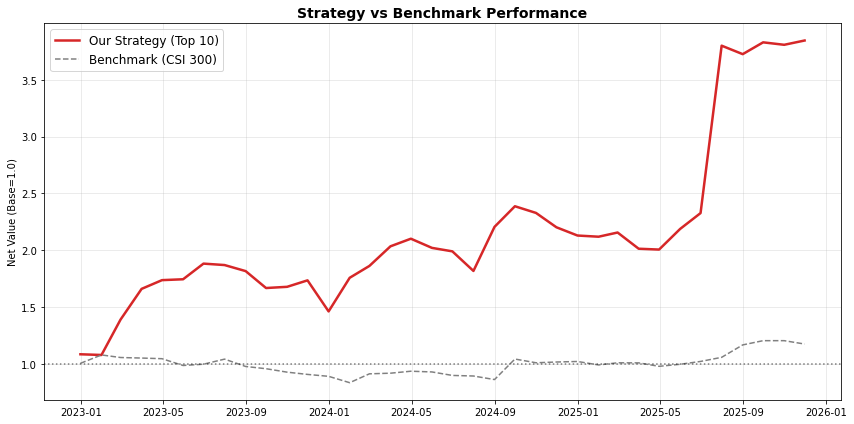

In [ ]:
# 绘制收益比较图
def plot_strategy_vs_benchmark_robust(strategy_df, benchmark_code='000300.SH'):
    """
    通过获取日线并重采样的方式，确保基准数据与策略数据时间轴完全对齐。
    """
    print(f"正在获取基准指数日线数据并重采样 ({benchmark_code})...")
    
    # 1. 确定时间范围 (稍微放宽一点，确保能算出来第一个月的收益)
    start_date_str = (strategy_df.index.min() - pd.Timedelta(days=60)).strftime('%Y%m%d')
    end_date_str = (strategy_df.index.max() + pd.Timedelta(days=10)).strftime('%Y%m%d')
    
    try:
        pro = ts.pro_api()
        # 获取指数日线
        df_bench_daily = pro.index_daily(ts_code=benchmark_code, start_date=start_date_str, end_date=end_date_str, fields='trade_date,close')
    except Exception as e:
        print(f" 无法获取指数数据: {e}")
        return

    if df_bench_daily.empty:
        print(" 获取到的指数数据为空，请检查 Token 或 权限。")
        return

    # 2. 数据清洗与重采样 (完全模仿股票数据的处理逻辑)
    df_bench_daily['trade_date'] = pd.to_datetime(df_bench_daily['trade_date'])
    df_bench_daily = df_bench_daily.set_index('trade_date').sort_index()
    
    # 强制重采样为月频 (取每月最后一天收盘价)
    # 注意：这里必须和处理股票数据时用的参数一致 ('ME' 或 'M')
    try:
        df_bench_monthly = df_bench_daily.resample('ME').last() 
    except:
        df_bench_monthly = df_bench_daily.resample('M').last()

    # 3. 计算月度收益率
    df_bench_monthly['Benchmark_Return'] = df_bench_monthly['close'].pct_change()
    
    # 4. Reindex
    # 我们以策略的索引为准，强制提取对应日期的基准收益
    
    comparison_df = pd.merge(
        strategy_df[['Strategy_Return']], 
        df_bench_monthly[['Benchmark_Return']], 
        left_index=True, 
        right_index=True, 
        how='inner' # 只保留两者都有的时间段
    )
    
    if comparison_df.empty:
        print(" 错误：策略日期与基准日期无法对齐。")
        print(f"策略日期样例: {strategy_df.index[:3]}")
        print(f"基准日期样例: {df_bench_monthly.index[:3]}")
        return

    # 5. 计算净值
    comparison_df['Strategy_Net_Value'] = (1 + comparison_df['Strategy_Return']).cumprod()
    comparison_df['Benchmark_Net_Value'] = (1 + comparison_df['Benchmark_Return']).cumprod()
    
    # 6. 打印最终指标
    final_strat_ret = comparison_df['Strategy_Net_Value'].iloc[-1] - 1
    final_bench_ret = comparison_df['Benchmark_Net_Value'].iloc[-1] - 1
    excess_ret = final_strat_ret - final_bench_ret
    
    print("\n" + "="*50)
    print(f"📊 {benchmark_code} 对比结果 ({len(comparison_df)} 个月)")
    print("="*50)
    print(f"策略累计收益: {final_strat_ret:.2%}")
    print(f"基准累计收益: {final_bench_ret:.2%}")
    print(f"超额收益 (Alpha): {excess_ret:.2%}")
    print("="*50)

    # 7. 绘图
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df.index, comparison_df['Strategy_Net_Value'], 
             label='Our Strategy (Top 10)', color='#d62728', linewidth=2.5)
    plt.plot(comparison_df.index, comparison_df['Benchmark_Net_Value'], 
             label='Benchmark (CSI 300)', color='gray', linestyle='--', linewidth=1.5)
    
    plt.axhline(y=1.0, color='black', linestyle=':', alpha=0.5)
    plt.title('Strategy vs Benchmark Performance', fontsize=14, fontweight='bold')
    plt.ylabel('Net Value (Base=1.0)')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
if __name__ == "__main__":
   
    plot_strategy_vs_benchmark_robust(weighted_returns, benchmark_code='000300.SH')

 正在全量数据上训练模型以提取特征重要性...

 Top 10 最重要特征 (基于 Gain/贡献度)
           Feature  Importance
0       Variance20    0.110413
1            ROC20    0.080600
2         Volume1M    0.055784
3            ATR14    0.048101
4             size    0.047187
5           PLRC12    0.043649
6        MACD_hist    0.043158
7        liquidity    0.040715
8  knn_mean_mom_1m    0.040709
9               BP    0.040160


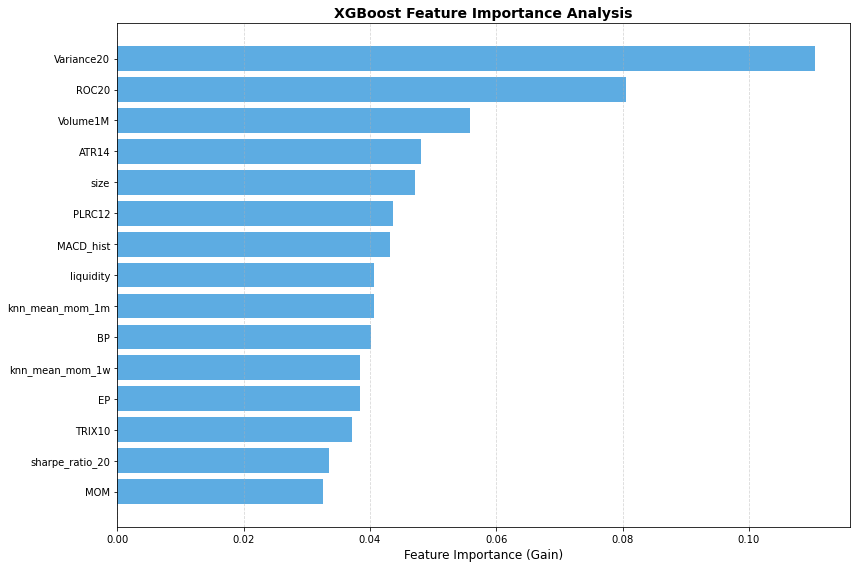

In [ ]:

def plot_feature_importance_analysis(full_df_processed, feature_cols, target_col='next_mth_return'):
    print(" 正在全量数据上训练模型以提取特征重要性...")
    
    # 1. 准备数据 (使用全部可用数据)
    # 移除缺失值
    clean_df = full_df_processed.dropna(subset=feature_cols + [target_col])
    
    X = clean_df[feature_cols].values
    y = clean_df[target_col].values
    
    # 2. 训练模型 (使用与回测相同的参数)
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(X, y)
    
    # 3. 提取重要性
    # get_booster().get_score(importance_type='gain') 通常比默认的 weight 更准确
    importance_dict = model.get_booster().get_score(importance_type='gain')
    
    # 映射回特征名
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1] # 降序排列
    
    # 创建 DataFrame
    feat_imp_df = pd.DataFrame({
        'Feature': [feature_cols[i] for i in indices],
        'Importance': importances[indices]
    })
    
    print("\n" + "="*50)
    print(" Top 10 最重要特征 (基于 Gain/贡献度)")
    print("="*50)
    print(feat_imp_df.head(10))
    print("="*50)
    
    # 4. 绘图
    plt.figure(figsize=(12, 8))
    
    # 为了美观，倒序画图，让最大的在上面
    top_features = feat_imp_df.head(15).sort_values('Importance', ascending=True)
    
    plt.barh(top_features['Feature'], top_features['Importance'], color='#3498db', alpha=0.8)
    plt.xlabel('Feature Importance (Gain)', fontsize=12)
    plt.title('XGBoost Feature Importance Analysis', fontsize=14, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ============================================================
# 执行绘图
# ============================================================
if __name__ == "__main__":
    plot_feature_importance_analysis(df_final, feature_cols)

正在计算 SHAP 值 (可能需要几分钟)...


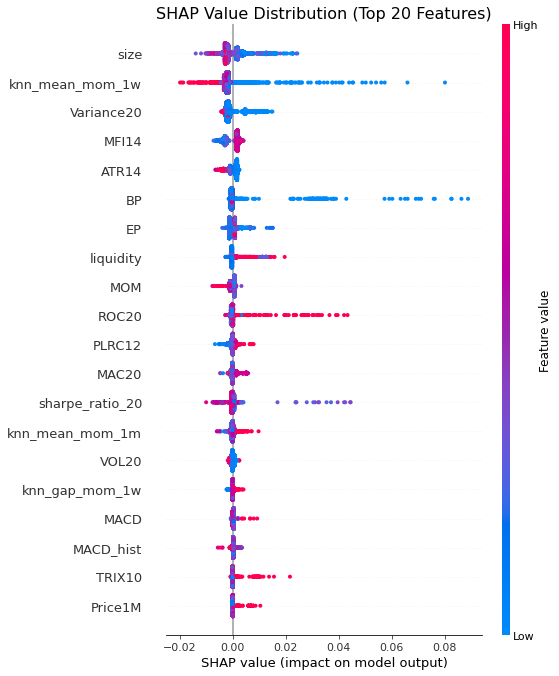

In [ ]:
#Shap分析
# 1. 准备工作
# 加载模型 
model = joblib.load('final_xgboost_model2.pkl') 
#model = final_model 

# 准备数据
# SHAP 计算非常耗时，不使用全量历史数据跑
sample_data = df_final.tail(5000) # 取最近的数据，更能反映当下的市场风格
X_shap = sample_data[feature_cols]

# 2. 创建解释器
print("正在计算 SHAP 值 ")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

# 3. 绘制核心摘要图 (Beeswarm Plot)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_shap, show=False)

# 调整字体和布局 (防止中文乱码)
plt.title(f"SHAP Value Distribution (Top 20 Features)", fontsize=16)
plt.tight_layout()
plt.show()